## Feature Engineering & Justification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from data_preprocessing import * 
from feature_engineering import * 

#### Data Loading

In [25]:
stormEvents_2014 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2014_c20231116.csv")
stormEvents_2015 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2015_c20240716.csv")
stormEvents_2016 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2016_c20220719.csv")
stormEvents_2017 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2017_c20230317.csv")
stormEvents_2018 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2018_c20240716.csv")
stormEvents_2019 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2019_c20240117.csv")
stormEvents_2020 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2020_c20240620.csv")
stormEvents_2021 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2021_c20240716.csv")
stormEvents_2022 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2022_c20241121.csv")
stormEvents_2023 = pd.read_csv("../data/NOAA_StormEvents/StormEvents_details-ftp_v1.0_d2023_c20241216.csv")

stormEvents_dfs = [stormEvents_2014, stormEvents_2015, stormEvents_2016, stormEvents_2017, stormEvents_2018,
       stormEvents_2019, stormEvents_2020, stormEvents_2021, stormEvents_2022, stormEvents_2023]


In [2]:
eaglei_outages_2014 = pd.read_csv("../data/eaglei_data/eaglei_outages_2014.csv")
eaglei_outages_2015 = pd.read_csv("../data/eaglei_data/eaglei_outages_2015.csv")
eaglei_outages_2016 = pd.read_csv("../data/eaglei_data/eaglei_outages_2016.csv")
eaglei_outages_2017 = pd.read_csv("../data/eaglei_data/eaglei_outages_2017.csv")
eaglei_outages_2018 = pd.read_csv("../data/eaglei_data/eaglei_outages_2018.csv")
eaglei_outages_2019 = pd.read_csv("../data/eaglei_data/eaglei_outages_2019.csv")
eaglei_outages_2020 = pd.read_csv("../data/eaglei_data/eaglei_outages_2020.csv")
eaglei_outages_2021 = pd.read_csv("../data/eaglei_data/eaglei_outages_2021.csv")
eaglei_outages_2022 = pd.read_csv("../data/eaglei_data/eaglei_outages_2022.csv")
eaglei_outages_2023 = pd.read_csv("../data/eaglei_data/eaglei_outages_2023.csv")


outages_dfs = [eaglei_outages_2014, eaglei_outages_2015, eaglei_outages_2016, eaglei_outages_2017, eaglei_outages_2018,
               eaglei_outages_2019, eaglei_outages_2020, eaglei_outages_2021, eaglei_outages_2022, eaglei_outages_2023]

In [ ]:
weather_data = load_data('../data/weather_data/weather_data.csv')

In [3]:
mcc = pd.read_csv("../data/eaglei_data/MCC.csv")

__________________________________________________________________________________

### NOAA_StormEvents

In [38]:
def summarize_overall_missing(dfs, names=None):
    summaries = []
    
    for i, df in enumerate(dfs):
        dataset_name = names[i] if names else f"stormEvents_{2014+i}"
        
        missing_count = df['MAGNITUDE'].isna().sum()
        present_count = df['MAGNITUDE'].notna().sum()
        total_count = len(df)
        
        summaries.append({
            'DATASET': dataset_name,
            'MISSING_MAGNITUDE': missing_count,
            'PRESENT_MAGNITUDE': present_count,
            'MISSING_PERCENT': round((missing_count / total_count) * 100, 2)
        })
    
    return pd.DataFrame(summaries)

In [39]:
summarize_overall_missing(stormEvents_dfs)

,DATASET,MISSING_MAGNITUDE,PRESENT_MAGNITUDE,MISSING_PERCENT
0,stormEvents_2014,29969,29506,50.39
1,stormEvents_2015,29273,28634,50.55
2,stormEvents_2016,24661,31344,44.03
3,stormEvents_2017,23330,33699,40.91
4,stormEvents_2018,34063,28634,54.33
5,stormEvents_2019,32244,35617,47.51
6,stormEvents_2020,26418,34861,43.11
7,stormEvents_2021,31333,30056,51.04
8,stormEvents_2022,36148,33738,51.72
9,stormEvents_2023,35327,40269,46.73


One of the most important columns in the Storm Events dataset is **MAGNITUDE**, which allows us to assess the intensity of events. Unfortunately, for most events, this column is empty, with around 50% of the data missing in each dataset and around 60% of missing data in **MAGNITUDE_TYPE**. As a result, we will not be able to use it.

### Eaglei_Outages

#### Cleaning datasets

We want to filter the `eaglei_outages_{year}` data frames in a way that preserves the highest quality data and correctly fills in any gaps. We do not want to lose data from excessively large territories to ensure our model performs as well as possible. At the same time, we want to exclude counties that reported the least consistently.

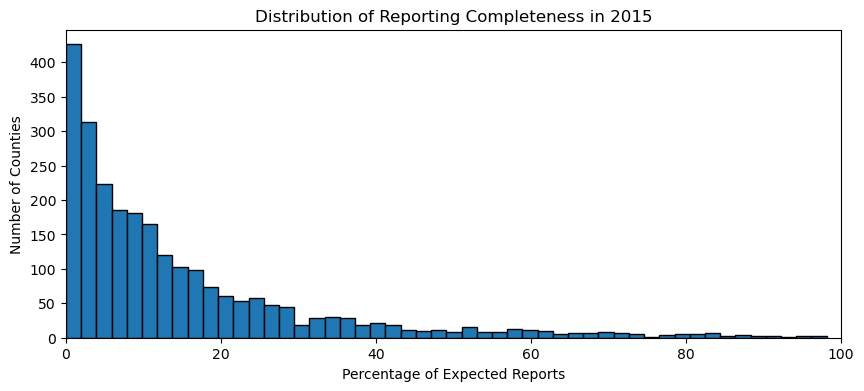

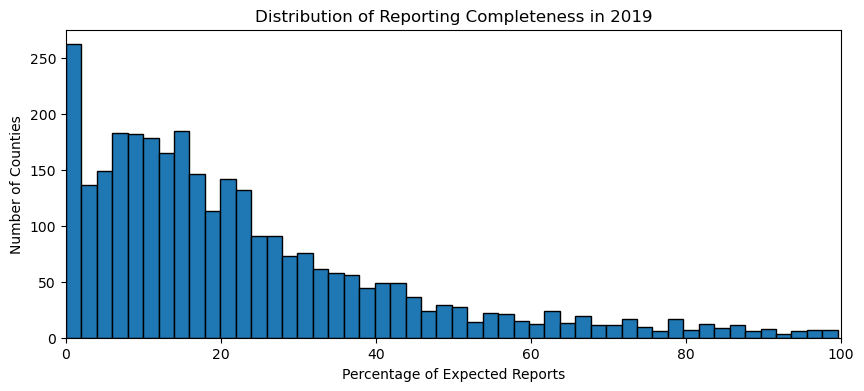

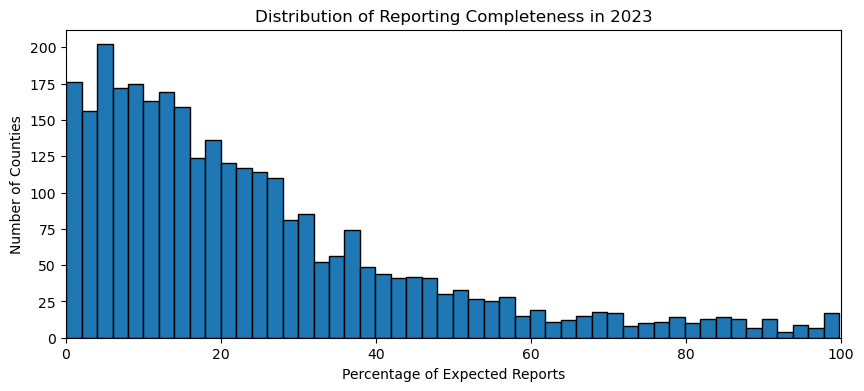

In [7]:
expected_reports = 4 * 24 * 365

plot_reporting_distribution(eaglei_outages_2015, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2019, 'run_start_time', expected_reports)
plot_reporting_distribution(eaglei_outages_2023, 'run_start_time', expected_reports)

Looking at the above summary, we see that a significant number of counties reported less frequently than once every 15 minutes. Since we plan to perform daily aggregation based on the collected weather data (while also considering that the model will have much broader practical applications if it can accurately predict the average number of people losing power in a given day), let's proceed with aggregation by calculating the average and see how this affects the reporting frequency.  

In [8]:
outages_dfs_agg = [aggregate_daily_outages(df) for df in outages_dfs]

In [9]:
outages_dfs_agg[9]

,date,fips_code,county,state,customers_out
0,2023-01-01,1001,Autauga,Alabama,3.827586
1,2023-01-01,1003,Baldwin,Alabama,27.584270
2,2023-01-01,1005,Barbour,Alabama,4.000000
3,2023-01-01,1007,Bibb,Alabama,4.000000
4,2023-01-01,1009,Blount,Alabama,4.000000
...,...,...,...,...,...
870384,2023-12-31,72113,Ponce,Puerto Rico,1710.780000
870385,2023-12-31,72127,San Juan,Puerto Rico,187.687500
870386,2023-12-31,78010,St. Croix,United States Virgin Islands,10.895833
870387,2023-12-31,78020,St. John,United States Virgin Islands,19.266667


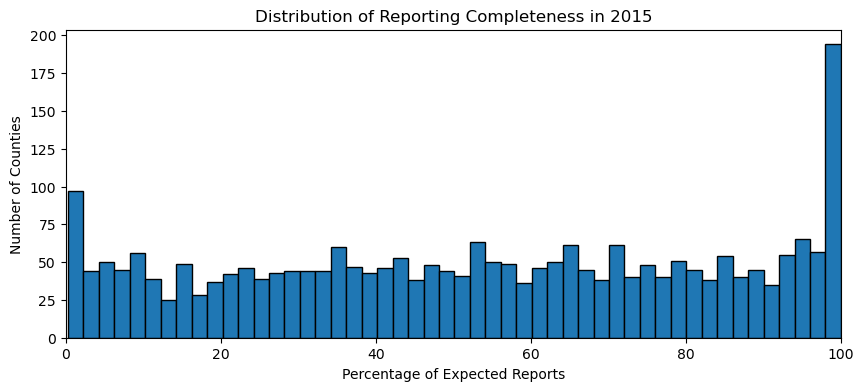

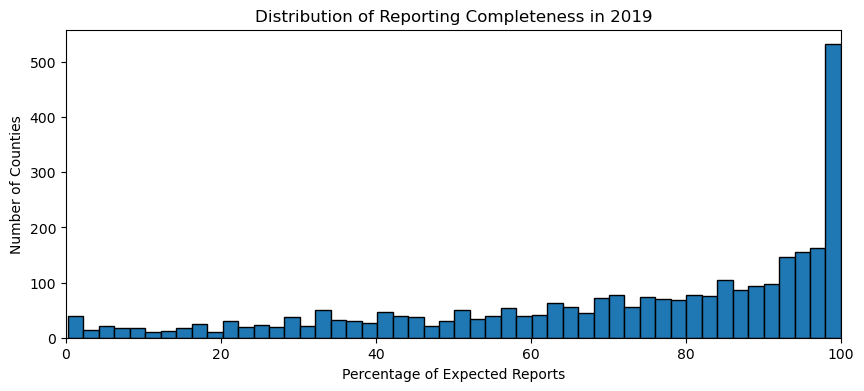

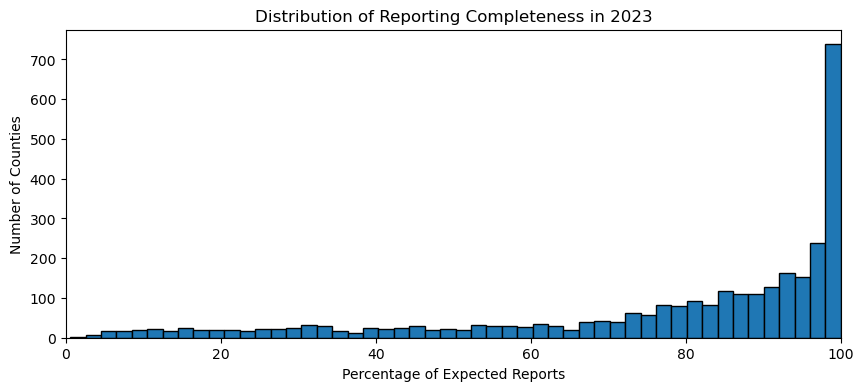

In [10]:
expected_reports = 365

plot_reporting_distribution(outages_dfs_agg[1], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[5], 'date', expected_reports)
plot_reporting_distribution(outages_dfs_agg[9], 'date', expected_reports)

Looking specifically at the final years in the dataset, we observe a striking improvement in data quality. The vast majority of counties report at least once a day. However, there are still some counties that report less frequently than we would expect.  

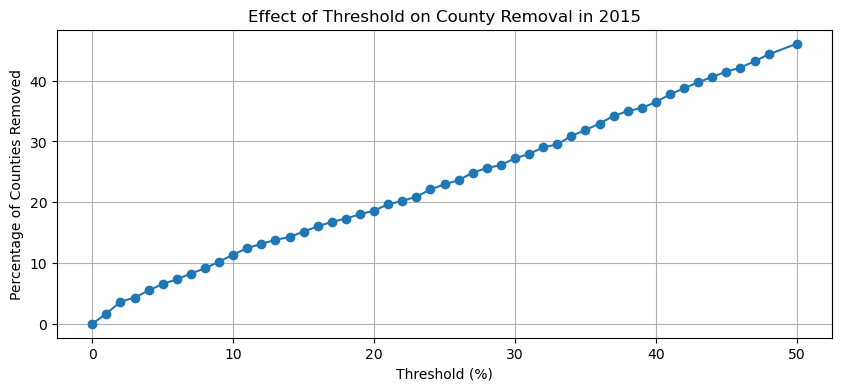

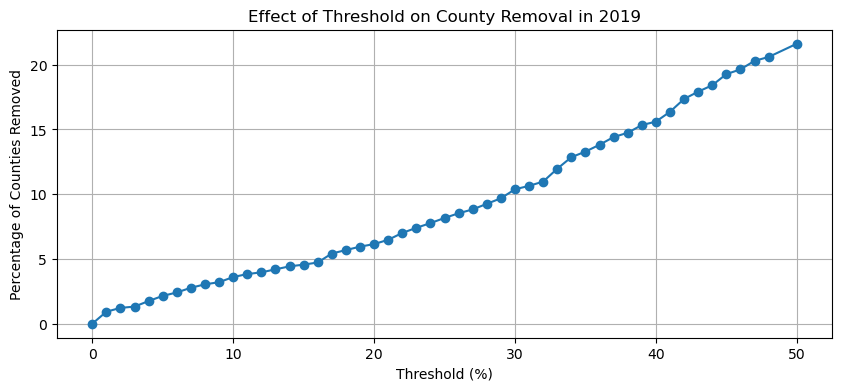

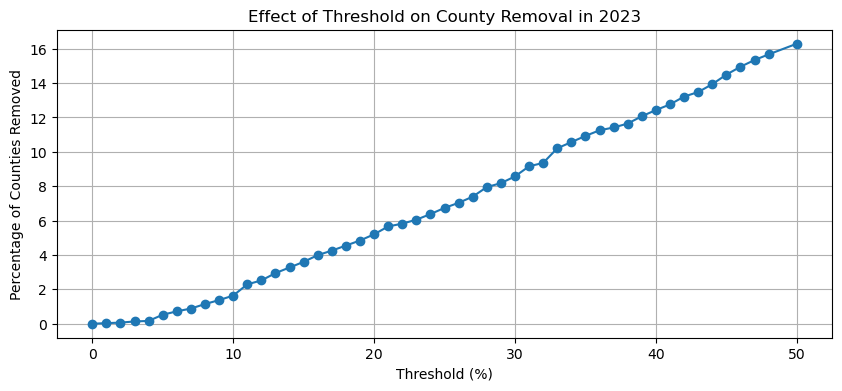

In [11]:
expected_reports = 365
thresholds = np.linspace(0, 50, 50, dtype=int)
plot_removal_effect(outages_dfs_agg[1], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[5], 'date', expected_reports, thresholds)
plot_removal_effect(outages_dfs_agg[9], 'date', expected_reports, thresholds)

After analyzing the data gaps and the number of counties removed in different years, we decide to set the threshold at 30. Counties that reported less frequently in a given year due to their lack of consistency contain low-quality data, and we do not want to include them in the model. For the counties that were more consistent, we will fill in the missing data.

In [12]:
expected_reports = 365
outages_dfs_agg_cl = [filter_low_reporting_counties(df, 'date', expected_reports, 30) for df in outages_dfs_agg]

#### U.S. Counties Population and Electricity Access Dataset

We will use new dataset that provides detailed population data by county in the United States. This dataset includes up-to-date information gathered from authoritative sources such as the U.S. Census Bureau and the Bureau of Labor Statistics.

This dataset is based on the freely available data from [SimpleMaps U.S. Counties Dataset](https://simplemaps.com/data/us-counties).

In [28]:
population_data = pd.read_csv('../data/population_data/uscounties.csv')
population_data = population_data[['county_fips', 'population']]

## TU MI BRAKUJE TYCH UZUPEŁNIONYCH DAT

In [40]:
import pandas as pd

def fill_missing_dates_optimized(eagle_outages, population_data):
    """
    This function adds missing dates for each unique (fips_code, county, state) combination 
    without generating the entire Cartesian product, keeping memory usage low.
    
    Parameters:
    eagle_outages (DataFrame): DataFrame containing outage data.
    population_data (DataFrame): DataFrame containing population data with columns:
                                 - 'county_fips' (str): FIPS code of the county.
                                 - 'population' (int): Population of the county.
    
    Returns:
    DataFrame: The updated DataFrame with missing dates added, without excessive memory usage.
    """
    
    # Convert 'date' column to datetime (if not already)
    eagle_outages['date'] = pd.to_datetime(eagle_outages['date'])
    
    # Generate all dates in the range from min to max date in the data
    start_date = eagle_outages['date'].min().replace(month=1, day=1)
    end_date = eagle_outages['date'].max().replace(month=12, day=31)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create a list of unique (fips_code, county, state) combinations
    unique_combinations = eagle_outages[['fips_code', 'county', 'state']].drop_duplicates()
    
    # For each combination, fill missing dates
    filled_outages = []
    for _, row in unique_combinations.iterrows():
        # Filter the data for the specific (fips_code, county, state)
        filtered_data = eagle_outages[(eagle_outages['fips_code'] == row['fips_code']) & 
                                      (eagle_outages['county'] == row['county']) & 
                                      (eagle_outages['state'] == row['state'])]
        
        # Create a DataFrame with all dates for this combination
        missing_dates = pd.DataFrame({'date': all_dates})
        missing_dates['fips_code'] = row['fips_code']
        missing_dates['county'] = row['county']
        missing_dates['state'] = row['state']
        
        # Merge the missing dates with the existing data
        merged_data = pd.merge(missing_dates, filtered_data, on=['fips_code', 'county', 'state', 'date'], how='left')
        
        # Add population information
        merged_data = merged_data.merge(population_data, how='left', left_on='fips_code', right_on='county_fips')
        
        filled_outages.append(merged_data)
    
    # Concatenate all the data back together
    final_data = pd.concat(filled_outages, ignore_index=True)
    
    # Calculate 'customer_out_percent'
    final_data['customer_out_percent'] = (final_data['customer_out'] / final_data['population']) * 100
    final_data.loc[final_data['customer_out_percent'] > 0, 'customer_out_percent'] = 100

    
    return final_data


In [41]:
outages_dfs_agg_cl[9][outages_dfs_agg_cl[9]['fips_code'] == 1001]

,date,fips_code,county,state,customers_out
0,2023-01-01,1001,Autauga,Alabama,3.827586
1852,2023-01-02,1001,Autauga,Alabama,6.252747
3861,2023-01-03,1001,Autauga,Alabama,27.177083
6200,2023-01-04,1001,Autauga,Alabama,529.552083
8516,2023-01-05,1001,Autauga,Alabama,3.954545
...,...,...,...,...,...
859884,2023-12-27,1001,Autauga,Alabama,3.500000
862214,2023-12-28,1001,Autauga,Alabama,8.500000
864518,2023-12-29,1001,Autauga,Alabama,307.142857
866651,2023-12-30,1001,Autauga,Alabama,4.000000


### DATA CLEANING

Missing values in the latitude and longitude columns will be filled using the geopy library, which can convert a place (like a county) into its corresponding latitude and longitude.

In [ ]:
nom = ArcGIS()
def get_coordinates(county_name):
    try:
        location = nom.geocode(county_name)
        if location:
            return location.latitude, location.longitude
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error geocoding {county_name}: {e}")
    return None, None

In [ ]:
for index, row in stormEvents_2014.iterrows():
    if pd.isna(row['BEGIN_LAT']) or pd.isna(row['BEGIN_LON']):
        lat, lon = get_coordinates(row['CZ_NAME'])
        if lat is not None and lon is not None:
            stormEvents_2014.at[index, 'BEGIN_LAT'] = lat
            stormEvents_2014.at[index, 'BEGIN_LON'] = lon
            stormEvents_2014.at[index, 'END_LAT'] = lat
            stormEvents_2014.at[index, 'END_LON'] = lon

In [ ]:
stormEvents_2014[['CZ_NAME', 'BEGIN_LAT', 'BEGIN_LON']]

## Columns summary ----- PYTANIE: CO Z TYMI KOLUMANMI O TORNADACH??????????

When preparing the NOAA Storm Events dataset for modeling, we carefully evaluated each column based on its relevance, interpretability, and potential predictive power.

## Columns Removed and Justification  

When preparing the dataset for analysis and modeling, we decided to remove certain columns that were redundant, had excessive missing values, or lacked predictive value. Below is a summary of our choices and reasoning:  

### Redundant Date & Time Columns  
These columns are unnecessary because we already have a comprehensive timestamp (`BEGIN_DATE_TIME`):  
- **BEGIN_YEARMONTH, BEGIN_DAY, BEGIN_TIME, YEAR, MONTH_NAME** – All information is contained within `BEGIN_DATE_TIME`.  
- **END_YEARMONTH, END_DAY, END_TIME, END_DATE_TIME** – In many cases, they mirror the corresponding "BEGIN" values.  

###  Identifiers with No Predictive Value  
These columns serve as unique identifiers but do not provide useful information for predictions:  
- **EPISODE_ID, EVENT_ID**  

###  Location and Metadata Redundancies  
These columns do not add meaningful information beyond what is already available in latitude, longitude, and other geographical data:  
- **WFO** – A regional code that does not provide direct weather-related insights.  
- **CZ_TIMEZONE** – We already have latitude, longitude, and time information.  
- **BEGIN_LOCATION / END_LOCATION** – We have precise latitude and longitude coordinates, making these redundant.  
- **END_LAT / END_LON** – In 50% cases, these values are identical to `BEGIN_LAT` and `BEGIN_LON`.  

###  Columns with Too Many Missing Values     
These columns have excessive missing values
- **MAGNITUDE / MAGNITUDE_TYPE** – Insufficient data coverage.  
- **FLOOD_CAUSE** 
- **TOR_F_SCALE, TOR_LENGTH, TOR_WIDTH** – Only applicable to tornadoes, and missing for all other event types.  
- **TOR_OTHER_WFO, TOR_OTHER_CZ_STATE, TOR_OTHER_CZ_FIPS, TOR_OTHER_CZ_NAME** 

###  Text-Based Columns (Not Used in Our Approach)  
These columns contain long text narratives, which we are not using since we are not applying NLP models:  
- **EPISODE_NARRATIVE, EVENT_NARRATIVE** 

###  Other Irrelevant Columns  
- **DATA_SOURCE** – Contains only one unique value, providing no useful information.  
- **SOURCE** – Lacks a clear predictive role 



% of rows whre BEGIN_LAT = BEGIN_LON

In [8]:
equal_percent = (stormEvents_2015["BEGIN_LON"] == stormEvents_2015["END_LON"]).mean() * 100

print(f"% rows, where BEGIN_LAT = BEGIN_LON: {equal_percent:.2f}%")

% rows, where BEGIN_LAT = BEGIN_LON: 46.17%


% of rows wheree END_AZIMUTH does not have value

In [9]:
missing_percent = stormEvents_2015["END_AZIMUTH"].isna().mean() * 100

print(f"% rows without value in END_AZIMUTH: {missing_percent:.2f}%")

% rows without value in END_AZIMUTH: 35.61%


### New Features  

1. **Category Column**  
   - We will use one-hot encoding to represent different types of catastrophes as separate features.  

2. **Creating New Columns**  
   - **`total_damages`** = `DAMAGE_PROPERTY` + `DAMAGE_CROPS`  
   - **`total_people_injuries`** = `DEATHS_DIRECT` + `DEATHS_INDIRECT` + `INJURIES_DIRECT` + `INJURIES_INDIRECT`  
   - **`percent_of_deaths`** = (`DEATHS_DIRECT` + `DEATHS_INDIRECT`) / `total_people_injuries`  

In [10]:
stormEvents_2015["total_damages"] = stormEvents_2015["DAMAGE_PROPERTY"] + stormEvents_2015["DAMAGE_CROPS"]
stormEvents_2015["total_people_injuries"] = (
    stormEvents_2015["DEATHS_DIRECT"] + stormEvents_2015["DEATHS_INDIRECT"] + 
    stormEvents_2015["INJURIES_DIRECT"] + stormEvents_2015["INJURIES_INDIRECT"]
)

stormEvents_2015["percent_of_deaths"] = (stormEvents_2015["DEATHS_DIRECT"] + stormEvents_2015["DEATHS_INDIRECT"]) / \
    stormEvents_2015["total_people_injuries"].replace(0, pd.NA)

columns_to_remove = [
    "DAMAGE_PROPERTY", "DAMAGE_CROPS", "DEATHS_DIRECT", "DEATHS_INDIRECT", "INJURIES_DIRECT", "INJURIES_INDIRECT"
]

stormEvents_2015 = stormEvents_2015.drop(columns=columns_to_remove)


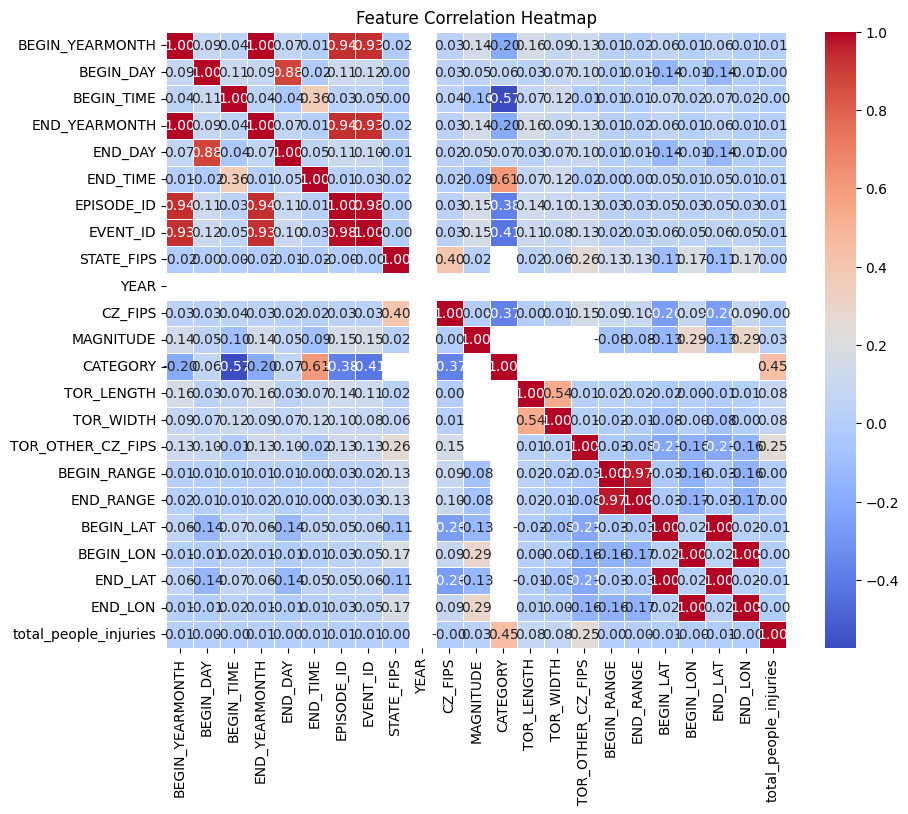

In [ ]:
numeric_cols = stormEvents_2015.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
